In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler,OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print(device)

cuda


In [4]:
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/base/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/base/test_category.csv"
test_data = pd.read_csv(test_data_path)

In [5]:
data['loan_status'] = data['loan_status'].apply(lambda x: 'Fully Paid' if x==0 else 'Default')

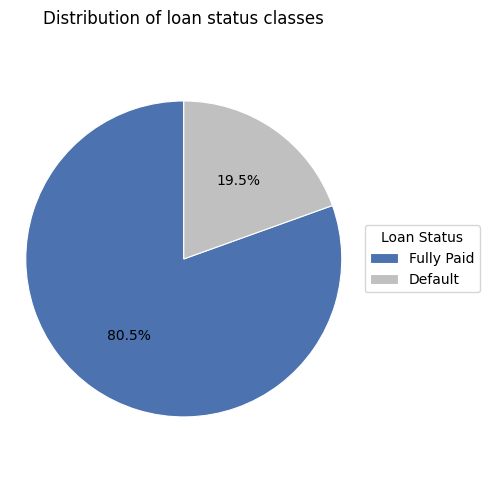

In [6]:
import matplotlib.pyplot as plt

# loan_status 분포 계산
counts = data['loan_status'].value_counts()
labels = counts.index
sizes = counts.values

# Pie chart (논문 스타일)
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct='%.1f%%',
    startangle=90,
    colors=['#4c72b0', '#c0c0c0'],  # 파랑 + 회색
    textprops={'fontsize': 10, 'color': 'black'},
    wedgeprops={'linewidth': 0.8, 'edgecolor': 'white'}
)

# 원형 유지
plt.axis('equal')

# 범례 추가 (차트 밖 오른쪽)
plt.legend(wedges, labels, title="Loan Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# 제목은 깔끔하게
plt.title("Distribution of loan status classes", fontsize=12, pad=10, loc='center')

plt.tight_layout()
plt.show()


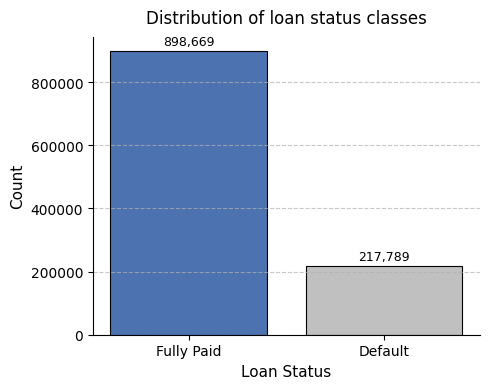

In [7]:
import matplotlib.pyplot as plt

# loan_status 분포 계산
counts = data['loan_status'].value_counts()
labels = counts.index
sizes = counts.values

# Bar chart (논문 스타일)
plt.figure(figsize=(5, 4))
bars = plt.bar(labels, sizes, color=['#4c72b0', '#c0c0c0'], edgecolor='black', linewidth=0.8)

# 값(label) 표시 (막대 위에 count 표시)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(sizes)*0.01,
             f'{height:,}', ha='center', va='bottom', fontsize=9)

# 제목, 축 스타일
plt.title("Distribution of loan status classes", fontsize=12, pad=10, loc='center')
plt.xlabel("Loan Status", fontsize=11)
plt.ylabel("Count", fontsize=11)

# 격자선은 y축만 약하게
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 테두리(상/오른쪽 축선 제거)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


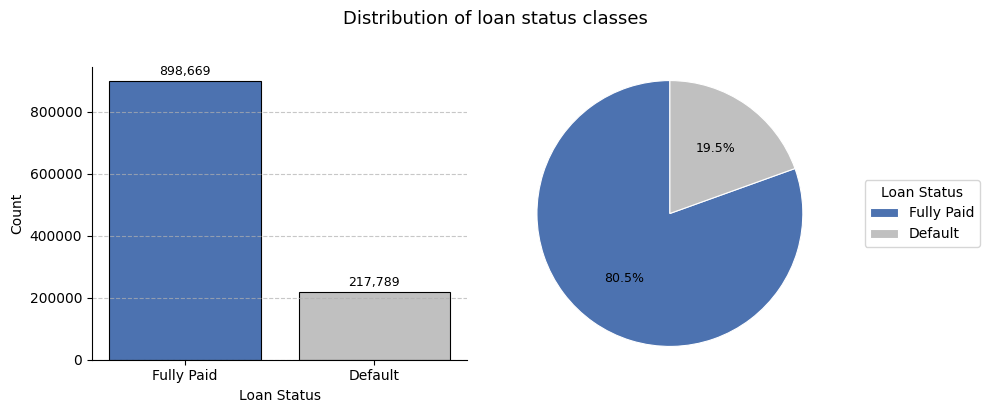

In [8]:
import matplotlib.pyplot as plt

# loan_status 분포 계산
counts = data['loan_status'].value_counts()
labels = counts.index
sizes = counts.values

# Figure 전체 생성
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --------------------
# 1. Pie chart (왼쪽)
# --------------------
wedges, texts, autotexts = axes[1].pie(
    sizes,
    autopct='%.1f%%',
    startangle=90,
    colors=['#4c72b0', '#c0c0c0'],
    textprops={'fontsize': 9, 'color': 'black'},
    wedgeprops={'linewidth': 0.8, 'edgecolor': 'white'}
)
axes[1].axis('equal')  # 원형 유지
plt.legend(wedges, labels, title="Loan Status", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
#axes[1].set_title("Pie Chart", fontsize=11)

# --------------------
# 2. Bar chart (오른쪽)
# --------------------
bars = axes[0].bar(labels, sizes, color=['#4c72b0', '#c0c0c0'],
                   edgecolor='black', linewidth=0.8)

# 막대 위 숫자 표시
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + max(sizes)*0.01,
                 f'{height:,}', ha='center', va='bottom', fontsize=9)

#axes[0].set_title("Bar Chart", fontsize=11)
axes[0].set_xlabel("Loan Status", fontsize=10)
axes[0].set_ylabel("Count", fontsize=10)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# 전체 Figure 제목
fig.suptitle("Distribution of loan status classes", fontsize=13, y=1.02)

plt.tight_layout()
plt.show()


In [4]:
test_data.describe()

,last_fico_range_high,annual_inc,dti,mo_sin_old_rev_tl_op,revol_util,int_rate,installment,avg_cur_bal,revol_bal,total_pymnt,total_pymnt_inv,funded_amnt,loan_amnt,credit_history_years,term_months,loan_status
count,744306.000000,7.443060e+05,744306.000000,744306.000000,744306.000000,744306.000000,744306.000000,744306.000000,7.443060e+05,744306.000000,744306.000000,744306.000000,744306.000000,744306.000000,744306.000000,744306.000000
mean,679.018287,7.731962e+04,18.572577,180.636256,0.504507,0.131775,440.370841,13629.729160,1.629202e+04,15171.417976,15152.635259,14583.501477,14589.791934,16.317230,42.023103,0.195070
std,82.449535,7.524759e+04,13.076324,94.239203,0.247945,0.048311,267.094325,16289.110866,2.258693e+04,10685.589930,10684.376590,8971.692685,8974.558867,7.603429,10.405616,0.396255
min,0.000000,0.000000e+00,-1.000000,2.000000,0.000000,0.053100,14.770000,0.000000,0.000000e+00,0.000000,0.000000,700.000000,700.000000,3.000000,36.000000,0.000000
25%,629.000000,4.600000e+04,11.830000,118.000000,0.316000,0.095800,246.990000,3193.000000,5.833000e+03,6901.486618,6883.957500,7925.000000,7925.000000,11.000000,36.000000,0.000000
50%,694.000000,6.500000e+04,17.710000,167.000000,0.505000,0.126900,373.750000,8048.000000,1.107400e+04,12304.238580,12289.525000,12000.000000,12000.000000,15.000000,36.000000,0.000000
75%,739.000000,9.200000e+04,24.280000,227.000000,0.695000,0.159900,584.960000,18311.750000,1.976400e+04,21114.071210,21093.845000,20000.000000,20000.000000,20.000000,60.000000,0.000000
max,850.000000,1.099920e+07,999.000000,901.000000,8.923000,0.309900,1719.830000,752994.000000,2.904836e+06,66714.370000,66714.370000,40000.000000,40000.000000,75.000000,60.000000,1.000000


In [5]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [6]:
test_classification.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [5]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [6]:
##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [7]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

def load_data_by_method(method):
    test_data = test_classification
    X_test = test_data.drop(columns='loan_status')
    y_test = test_data[['loan_status']]

    base_data = data_classification

    if method == 'Base':
        X_train = base_data.drop(columns='loan_status')
        y_train = base_data[['loan_status']]

    elif method == 'Undersampling':
        data_x = base_data.drop(columns='loan_status')
        data_y = base_data[['loan_status']]
        X_temp, _, y_temp, _ = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
        rus = RandomUnderSampler(random_state=42)
        X_under, y_under = rus.fit_resample(X_temp, y_temp)
        X_train, y_train = X_under, y_under

    elif method == 'SMOTE-NC':
        smote_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/smotenc/smotenc_data.csv"
        smote_data = pd.read_csv(smote_path)
        drop_cols = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt', 'funded_amnt']
        smote_data = smote_data.drop(columns=drop_cols)
        smote_data = encode_features(smote_data, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        X_train = smote_data.drop(columns='loan_status')
        y_train = smote_data[['loan_status']]

    else:
        fake_base = {
            'table-gan': 'tablegan/tablegan.csv',
            'vae-tablegan': 'tablegan/vae-tablegan.csv',
            'ctgan': 'ctgan/ctgan.csv',
            'vae-ctgan': 'ctgan/vae-ctgan.csv',
            'ctabgan': 'ctabgan/ctabgan.csv',
            'vae-ctabgan': 'ctabgan/vae-ctabgan.csv'
        }

        if method not in fake_base:
            raise ValueError(f"Unknown method: {method}")

        fake_path = f"C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/{fake_base[method]}"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1  # 모든 fake는 default

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt', 'funded_amnt']
        fake = fake.drop(columns=keep_features)
        fake['term_months'] = fake['term_months'].apply(lambda x: 36 if abs(x - 36) < abs(x - 60) else 60)
        fake = encode_features(fake, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        base_x = base_data.drop(columns='loan_status')
        base_y = base_data[['loan_status']]
        X_base, _, y_base, _ = train_test_split(base_x, base_y, test_size=0.2, stratify=base_y, random_state=42)
        train_real = pd.concat([X_base, y_base], axis=1)
        train_total = pd.concat([train_real, fake])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

    return X_train, y_train, X_test, y_test

In [9]:
summary_with_sharpe_top = []

summary_with_grade_top = []

def linear_portfolio_top(Method, top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['funded_amnt']) / selected['funded_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe_top.append({
        'Method': Method,
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

    A_count = len(selected[selected['grade'] == 'A'])
    B_count = len(selected[selected['grade'] == 'B'])
    C_count = len(selected[selected['grade'] == 'C'])
    D_count = len(selected[selected['grade'] == 'D'])
    E_count = len(selected[selected['grade'] == 'E'])
    F_G_count = len(selected[selected['grade'] == 'F']) + len(selected[selected['grade'] == 'G'])

    summary_with_grade_top.append({
        'Method': Method,
        'A': A_count,
        'B': B_count,
        'C': C_count,
        'D': D_count,
        'E': E_count,
        'F+G': F_G_count,
        'Total': len(selected)
    }) 

In [10]:
##상위 10% 투자
from imblearn.over_sampling import SMOTE
drop2 = ['loan_status', 'return']

def select_fully_paid(y_pred, method):
    scaler = StandardScaler()
    reg = LinearRegression()

    fully_paid_indices = (y_pred == 0)
    test_regression = test_data[fully_paid_indices]
    test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['funded_amnt'])/test_regression['funded_amnt']

    train_regression = data.copy()

    if method == 'Base':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']

        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        data_x = train_regression.drop(columns='return')
        data_y = train_regression[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))
        return method, top_10_percent
    
    elif method == 'Undersampling':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['funded_amnt']
        drop_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train = train_regression.drop(columns='loan_status')
        y_train = train_regression[['loan_status']]

        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=X_train.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

        data_x = data_under.drop(columns=drop2)  
        data_y = data_under[['return']]  

        test_x = test_regression.drop(columns = drop2)
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))

        return method, top_10_percent
    
    elif method == 'SMOTE-NC':
        smote_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/smotenc/smotenc_data.csv"
        data_smote = pd.read_csv(smote_path)
        
        data_smote['return'] = (data_smote['total_pymnt_inv'] - data_smote['funded_amnt'])/data_smote['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

        train_regression = data_smote.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train = train_regression.drop(columns='return')
        y_train = train_regression[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(X_train)

        X_train = data_x_scaled
        #y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))

        return method, top_10_percent
    
    elif method == 'table-gan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))

        return method, top_10_percent
        
    
    elif method == 'vae-tablegan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/vae-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))

        return method, top_10_percent 
    
    elif method == 'ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))

        return method, top_10_percent 
    
    
    elif method == 'vae-ctgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)

        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))

        return method, top_10_percent 
    

    elif method == 'ctabgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctabgan/ctabgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        
        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))

        return method, top_10_percent 
    

    elif method == 'vae-ctabgan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['funded_amnt'])/train_regression['funded_amnt']
        drop_features = ['loan_status','grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)
        
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctabgan/vae-ctabgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['funded_amnt'])/fake_regression['funded_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)
        fake_regression['term_months'] = fake_regression['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        
        train_regression = encode_features(train_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        test_regression = encode_features(test_regression, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        fake_regression = encode_features(fake_regression,label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.3))

        return method, top_10_percent 
    

In [11]:
from sklearn.utils import shuffle

classification_metrics_summary = []

def return_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2,
                                                           random_state=42, stratify=data_y)
        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)


    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE-NC':
        smote_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/smotenc/smotenc_data.csv"
        data_smote = pd.read_csv(smote_path)

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        data_smote_classification = data_smote.copy()
        data_smote_classification = data_smote_classification.drop(columns = keep_features)

        data_smote_classification = encode_features(data_smote_classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        data_x = data_smote_classification.drop(columns='loan_status') 
        data_y = data_smote_classification[['loan_status']]

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'vae-tablegan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/vae-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    
    elif method == 'vae-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
        
    
    elif method == 'ctabgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctabgan/ctabgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    
    elif method == 'vae-ctabgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctabgan/vae-ctabgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    report = classification_report(
        y_test, y_pred,
        target_names=["Fully Paid", "Default"],
        output_dict=True,
        zero_division=0
    )

    classification_metrics_summary.append({
        "Method": method,
        "Class 0 Precision": report["Fully Paid"]["precision"],
        "Class 0 Recall": report["Fully Paid"]["recall"],
        "Class 0 F1": report["Fully Paid"]["f1-score"],
        "Class 1 Precision": report["Default"]["precision"],
        "Class 1 Recall": report["Default"]["recall"],
        "Class 1 F1": report["Default"]["f1-score"],
        "Macro Avg F1": report["macro avg"]["f1-score"],
        "Weighted Avg F1": report["weighted avg"]["f1-score"],
    })

    #10% index뽑기기
    Method, top_10_indices = select_fully_paid(y_pred, method)

    #portfolio 만들기들기
    linear_portfolio_top(Method, top_10_indices)

In [12]:
methods = [
    'Base', 'Undersampling', 'SMOTE-NC',
    'table-gan',  'vae-tablegan',
    'ctgan',  'vae-ctgan',
    'ctabgan', 'vae-ctabgan'
]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

returns_df = pd.DataFrame()

for method in methods:
    data_x = data_classification.drop(columns='loan_status')
    data_y = data_classification['loan_status']

    model = LGBMClassifier(
        learning_rate=0.01,
        n_estimators=500,               
        device='cpu',
        verbosity=-1,
        random_state=42
    )
    
    return_evaluation(model, data_x, data_y, X_test, y_test, method)

#classification 결과
classification_metrics_df = pd.DataFrame(classification_metrics_summary)

#상위 10% 투자전략
returns_with_sharpe_df_top = pd.DataFrame(summary_with_sharpe_top)
portfolio_grade_distribution_df_top = pd.DataFrame(summary_with_grade_top)

Preprocessing method : Base
RMSE: 0.19724239831874127
R²: 0.016356161994040885
Preprocessing method : Undersampling
RMSE: 0.2007067594710921
R²: -0.6261143279074499
Preprocessing method : SMOTE-NC
RMSE: 0.21738932909898348
R²: -0.4388215339785775
Preprocessing method : table-gan
RMSE: 0.22283512191911087
R²: -0.2932030258814302
Preprocessing method : vae-tablegan
RMSE: 0.19711916977635202
R²: 0.01713664028480333
Preprocessing method : ctgan
RMSE: 0.20417476204372026
R²: -0.4387418751424177
Preprocessing method : vae-ctgan
RMSE: 0.19714586790744248
R²: 0.01727389074379415
Preprocessing method : ctabgan
RMSE: 0.32584135834426026
R²: -2.1225462244435604
Preprocessing method : vae-ctabgan
RMSE: 0.18743344332452533
R²: -0.2581912507621018


In [13]:
classification_metrics_df.head(15)

,Method,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 1 Precision,Class 1 Recall,Class 1 F1,Macro Avg F1,Weighted Avg F1
0,Base,0.942686,0.947614,0.945144,0.779072,0.762267,0.770578,0.857861,0.911091
1,Undersampling,0.975915,0.877935,0.924336,0.643858,0.910594,0.754341,0.839338,0.891175
2,SMOTE-NC,0.959110,0.920835,0.939583,0.719523,0.838008,0.774258,0.856921,0.907333
3,table-gan,0.945213,0.939414,0.942305,0.756173,0.775318,0.765626,0.853965,0.907840
4,vae-tablegan,0.942778,0.947541,0.945153,0.778926,0.762687,0.770721,0.857937,0.911127
5,ctgan,0.965947,0.903003,0.933415,0.684572,0.868643,0.765700,0.849558,0.900699
6,vae-ctgan,0.942752,0.947583,0.945161,0.779035,0.762563,0.770711,0.857936,0.911131
7,ctabgan,0.956067,0.926652,0.941130,0.731435,0.824295,0.775093,0.858111,0.908741
8,vae-ctabgan,0.969249,0.896581,0.931500,0.674083,0.882624,0.764386,0.847943,0.898901


In [14]:
returns_with_sharpe_df_top.head(15)

,Method,Average Return,Std Dev,Sharpe Ratio
0,Base,17.202054,0.147956,1.162645
1,Undersampling,14.814365,0.125718,1.178380
2,SMOTE-NC,14.571902,0.124408,1.171299
3,table-gan,14.009027,0.118714,1.180069
4,vae-tablegan,15.836188,0.132309,1.196909
5,ctgan,14.791409,0.121213,1.220286
6,vae-ctgan,15.836051,0.132305,1.196931
7,ctabgan,15.116245,0.190455,0.793690
8,vae-ctabgan,15.373828,0.129282,1.189172


In [15]:
portfolio_grade_distribution_df_top.head(15)

,Method,A,B,C,D,E,F+G,Total
0,Base,35359,49894,49811,26252,13443,5914,180673
1,Undersampling,48518,50673,37532,15521,6831,2614,161689
2,SMOTE-NC,52201,54241,39630,17423,6621,2445,172561
3,table-gan,48556,56500,43489,21019,6932,2135,178631
4,vae-tablegan,43903,55385,46053,22614,9181,3506,180642
5,ctgan,49168,54384,39610,16615,6168,2077,168022
6,vae-ctgan,43908,55388,46057,22615,9181,3506,180655
7,ctabgan,13012,46789,58407,36047,14319,5630,174204
8,vae-ctabgan,46338,50249,39541,19075,7955,3100,166258


In [16]:
portfolio_grade = portfolio_grade_distribution_df_top.copy()

grade_columns = ['A', 'B', 'C', 'D', 'E', 'F+G']

for col in grade_columns:
    portfolio_grade[col] = (portfolio_grade[col] / portfolio_grade['Total']) * 100
    portfolio_grade[col] = round(portfolio_grade[col],2)

# 결과 출력
print(portfolio_grade[[col for col in grade_columns]])


       A      B      C      D     E   F+G
0  19.57  27.62  27.57  14.53  7.44  3.27
1  30.01  31.34  23.21   9.60  4.22  1.62
2  30.25  31.43  22.97  10.10  3.84  1.42
3  27.18  31.63  24.35  11.77  3.88  1.20
4  24.30  30.66  25.49  12.52  5.08  1.94
5  29.26  32.37  23.57   9.89  3.67  1.24
6  24.30  30.66  25.49  12.52  5.08  1.94
7   7.47  26.86  33.53  20.69  8.22  3.23
8  27.87  30.22  23.78  11.47  4.78  1.86


In [17]:
portfolio_grade.head(15)

,Method,A,B,C,D,E,F+G,Total
0,Base,19.57,27.62,27.57,14.53,7.44,3.27,180673
1,Undersampling,30.01,31.34,23.21,9.60,4.22,1.62,161689
2,SMOTE-NC,30.25,31.43,22.97,10.10,3.84,1.42,172561
3,table-gan,27.18,31.63,24.35,11.77,3.88,1.20,178631
4,vae-tablegan,24.30,30.66,25.49,12.52,5.08,1.94,180642
5,ctgan,29.26,32.37,23.57,9.89,3.67,1.24,168022
6,vae-ctgan,24.30,30.66,25.49,12.52,5.08,1.94,180655
7,ctabgan,7.47,26.86,33.53,20.69,8.22,3.23,174204
8,vae-ctabgan,27.87,30.22,23.78,11.47,4.78,1.86,166258
